# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
import math

class_counts = [8, 2]

total_count = sum(class_counts)
H = 0.0

for count in class_counts:
    if count > 0:
        probability = count / total_count
        H -= probability * math.log(probability)

print(f"Энтропия равна {H:.2f}")

Энтропия равна 0.50


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
#для удобства напишем функцию для подсчета джини в зависимости от классов, подающихс на вход
def calc_gini(class_counts):
    total_count = sum(class_counts)
    gini = 0.0

    for count in class_counts:
        if count > 0:
            probability = count / total_count
            gini += probability * (1 - probability)

    return gini

#зададим разбиение классов по вершинам
class_counts = [8, 2]
class_counts_left = [8, 0]
class_counts_right = [0, 2]

Q = calc_gini(class_counts) - calc_gini(class_counts_left) - calc_gini(class_counts_left)

print(f"Индекс Джини равен {Q:.2f}")


Индекс Джини равен 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
#предсказание будет равно среднему всех объектов
np.mean([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [6]:
def gini_index (y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    gini = np.sum(probabilities * (1 - probabilities))
    return gini

def q_error(task, R_l, R_r, feature_vector) -> float:
    if len(R_l) == 0 or len(R_r) == 0:
        return float('inf')
    if task == "classification":
        return len(R_l) / len(feature_vector) * gini_index(R_l) + len(R_r) / len(feature_vector) * gini_index(R_r)
    else:
        return len(R_l) / len(feature_vector) * np.var(R_l) + len(R_r) / len(feature_vector) * np.var(R_r)
        

def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    #создаем массив порогов — это отсортированный массив наших фичей
    thresholds = np.array(sorted(np.unique(feature_vector)))
    #создаем пустой лист, куда будем класть значения критерия 
    #джини для классификации, либо же значения дисперсий подвыборки для регресии
    ginis = list()
    
    #пишем условную конструкцию по тому, как мы будем определять пороги, затем считаем критерии информативности и ошибки
    if feature_type == 'real':
        thresholds = (thresholds [1:]+thresholds[:-1])/2
    if feature_type == 'categorical':
        for t in thresholds:
            mask = feature_vector == t
            R_l, R_r = target_vector[mask], target_vector[~mask] 
            ginis.append(q_error(task, R_l, R_r, feature_vector))
    else:    
        for t in thresholds:
            ginis.append(q_error(task, target_vector[(feature_vector > t)],
                           target_vector[~(feature_vector > t)], feature_vector))
    
    ginis = np.array(ginis)
    threshold_best = thresholds[ginis.argmin()]
    gini_best = min(ginis)
    
    return thresholds, ginis, threshold_best, gini_best

Эту функцию можно протестировать на датасете `California`.

In [7]:
from sklearn.datasets import fetch_california_housing

In [8]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [9]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

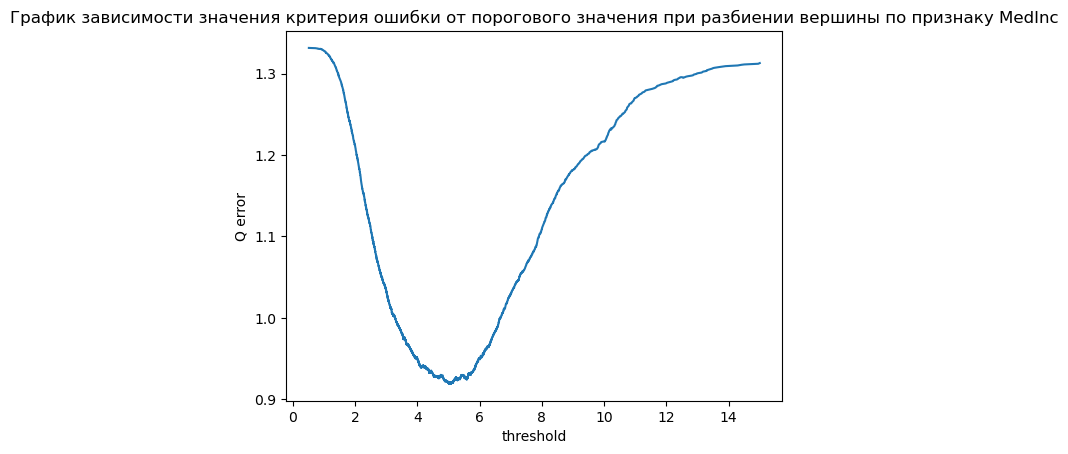

In [10]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["MedInc"].to_numpy(),
    y,
    task="regression",
    feature_type="real"
)
plt.plot(thresholds, variances)
plt.title('График зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку MedInc')
plt.xlabel("threshold")
plt.ylabel("Q error")
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [11]:
threshold_best #лучший предикат корневой вершины

5.03515

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [12]:
class DecisionTree:
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
    
        stack = [(sub_X, sub_y, node)]
    
        while stack:
            sub_X, sub_y, node = stack.pop()
        
            if np.all(sub_y == sub_y[0]):
                node["type"] = "terminal"
                node["class"] = sub_y[0]
                continue

            feature_best, threshold_best, gini_best, split = None, None, None, None
            for feature in range(sub_X.shape[1]):
                feature_type = self._feature_types[feature]
                categories_map = {}

                if feature_type == "real":
                    feature_vector = sub_X[:, feature]
                elif feature_type == "categorical":
                    feature_vector = sub_X[:, feature]

                _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

                if gini_best is None or gini > gini_best:
                    feature_best = feature
                    gini_best = gini
                    if feature_type == "real":
                        threshold_best = threshold
                        split = feature_vector > threshold
                    elif feature_type == "categorical":
                        threshold_best = threshold
                        split = feature_vector == threshold
                    else:
                        raise ValueError

            if feature_best is None:
                node["type"] = "terminal"
                node["class"] = Counter(sub_y).most_common(1)[0][0]
                continue

            node["type"] = "nonterminal"
            node["feature_split"] = feature_best
            if self._feature_types[feature_best] == "real":
                node["threshold"] = threshold_best
            elif self._feature_types[feature_best] == "categorical":
                node["category_split"] = threshold_best
            else:
                raise ValueError
            
            node["left_child"], node["right_child"] = {}, {}
            left_split, right_split = sub_X[split], sub_X[np.logical_not(split)]
            left_y, right_y = sub_y[split], sub_y[np.logical_not(split)]

            if len(left_split) == 0 or len(right_split) == 0:
                node["type"] = "terminal"
                node["class"] = Counter(sub_y).most_common(1)[0][0]
                continue

            stack.append((right_split, right_y, node["right_child"]))
            stack.append((left_split, left_y, node["left_child"]))


    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        while node['type'] != 'terminal':
            feature_split = node['feature_split']
            feature_type = self._feature_types[node['feature_split']]
            
            if feature_type == 'real':
                if x[feature_split] > node['threshold']:
                    node = node['left_child']
                else:
                    node = node['right_child']
            else:
                if x[feature_split] == node['category_split']:
                    node = node['left_child']
                else:
                    node = node['right_child']
                   
        return node['class']

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [13]:
df = pd.read_csv('students.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


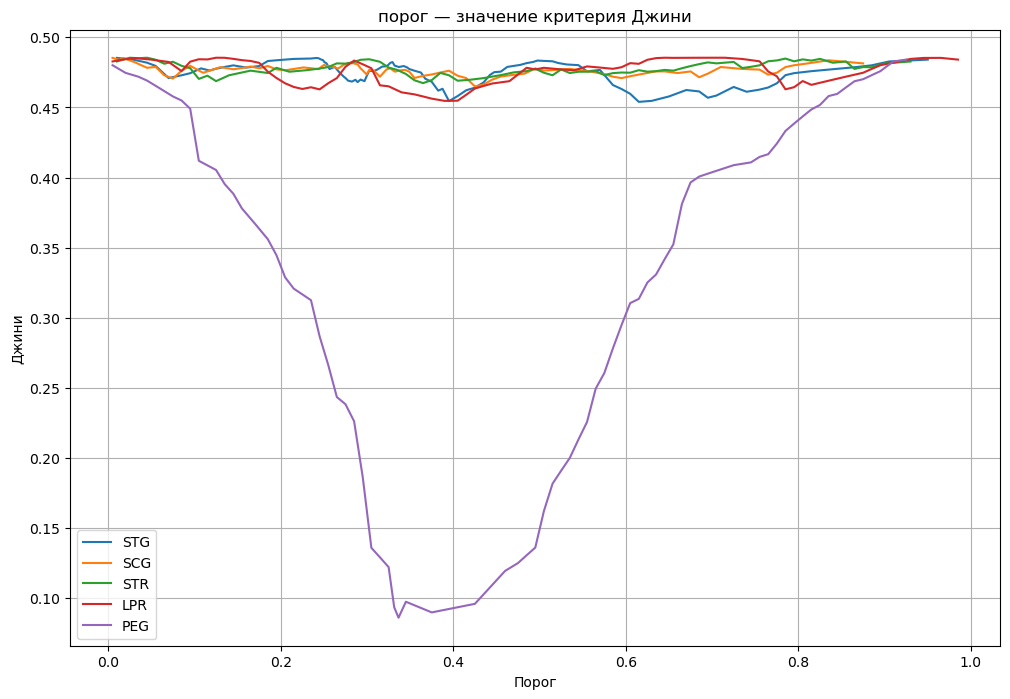

In [14]:
features = df.drop('UNS', axis=1)
target = df['UNS']

plt.figure(figsize=(12, 8))
for column in features.columns:
    feature_vector = features[column]
    thresholds, ginis, threshold_best, gini_best = find_best_split(feature_vector, target, task='classification', feature_type='real')
    plt.plot(thresholds, ginis, label=column)
plt.xlabel('Порог')
plt.ylabel('Джини')
plt.title('порог — значение критерия Джини')
plt.legend()
plt.grid()
plt.show()

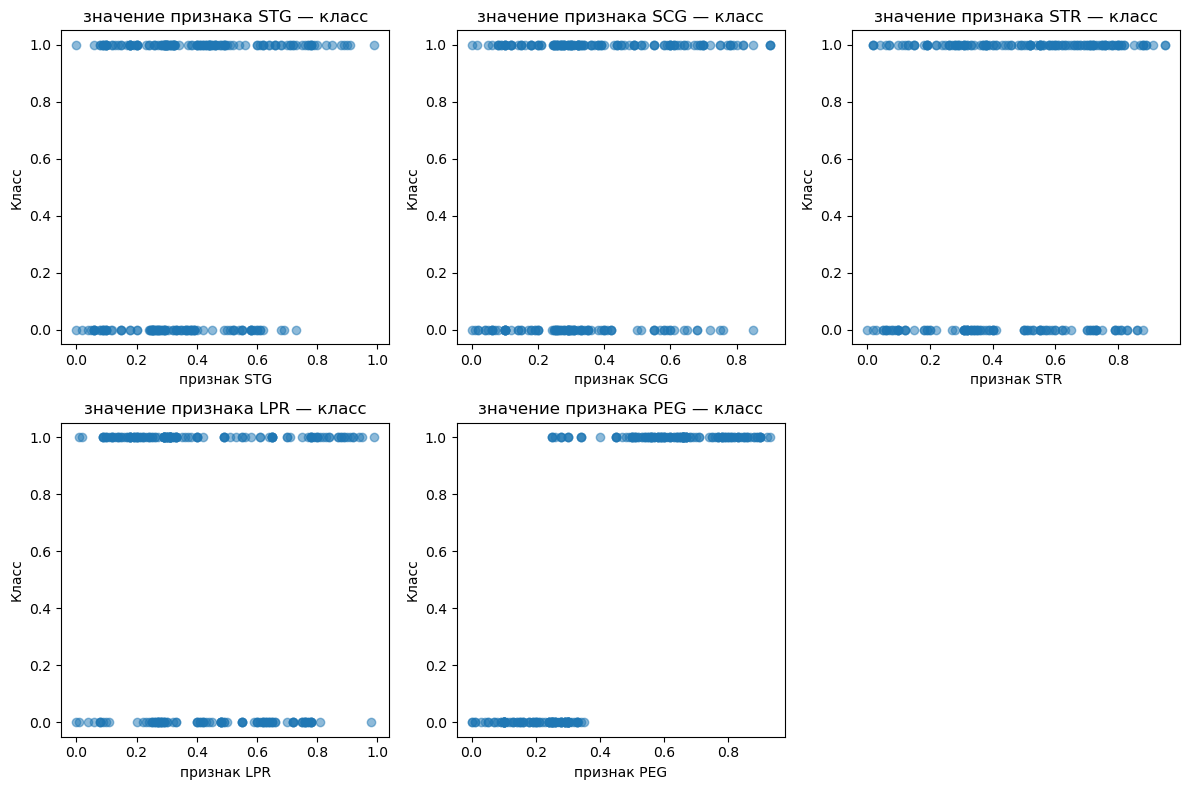

In [15]:
plt.figure(figsize=(12, 8))
for i, column in enumerate(features.columns, 1):
    plt.subplot(2, 3, i)
    plt.scatter(features[column], target, alpha=0.5)
    plt.xlabel(f'признак {column}')
    plt.ylabel('Класс')
    plt.title(f'значение признака {column} — класс')
plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

как вы видим, так называемым «хорошим» признаком можно назвать PEG, именно на нем
достигается минимальный Джини, что видно на графике, также видно, 
что именно по признаку PEG выборка делится почти идеально (предикатом будет являться значение ~0.37)

в остальных же признаком достатоно высокий джини => разделить их корректно по какому-либо предикату нереально,
а на скаттерах этих же признаком видно, что с одним и тем же значением признака объекты классифицированы по-разному

так, через точки скатерра хорошего признака можно провести своебразную сигмоиду, а что касается кривых, то на хороших
признаках должны быть своего рода впадины, которые сигнализирволи бы о наименьшем джини, а следовательно и о самом 
лучшем разбиении

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [16]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
mushroom = fetch_ucirepo(id=73) 
  
# data (as pandas dataframes) 
X = mushroom.data.features 
y = mushroom.data.targets

In [17]:
X

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,k,s,n,f,n,a,c,b,y,e,...,s,o,o,p,o,o,p,b,c,l
8120,x,s,n,f,n,a,c,b,y,e,...,s,o,o,p,n,o,p,b,v,l
8121,f,s,n,f,n,a,c,b,n,e,...,s,o,o,p,o,o,p,b,c,l
8122,k,y,n,f,y,f,c,n,b,t,...,k,w,w,p,w,o,e,w,v,l


In [18]:
y['poisonous'] = y['poisonous'].apply(lambda x: 1 if x == 'p' else 0)
y

/var/folders/xj/prnvhthd0nj65pjy_v_mtsr80000gn/T/ipykernel_17323/2560982652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['poisonous'] = y['poisonous'].apply(lambda x: 1 if x == 'p' else 0)


,poisonous
0,1
1,0
2,0
3,1
4,0
...,...
8119,0
8120,0
8121,0
8122,1


In [19]:
X.columns

Index(['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
encoder = LabelEncoder()

for column in X.columns:
    X[column] = encoder.fit_transform(X[column])

y = encoder.fit_transform(y)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

feature_types = ["categorical"] * X_train.shape[1]
tree = DecisionTree(feature_types=feature_types, task="classification")
tree.fit(X_train.to_numpy(), y_train)

# Предсказание на тестовых данных
y_pred = tree.predict(X_test.to_numpy())

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5133


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [322]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [323]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [324]:
data.shape

(768, 9)

Посмотрим на распределение целевой переменной

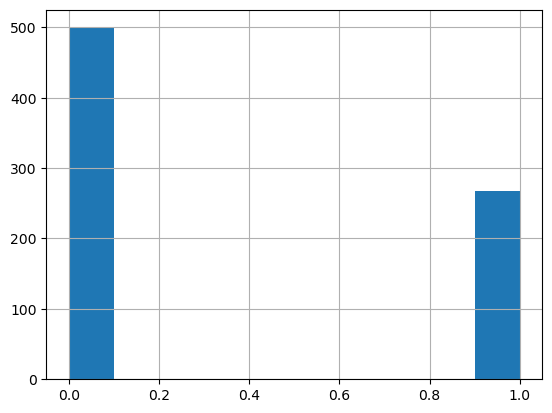

In [325]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [326]:
X = data.drop(columns=['Outcome'])
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [327]:
#задаем максимальную глубину дерева и минимальное количество объектов в каждом листе
max_depth_values = [3, 5, 7, 9, 15]
min_samples_leaf_values = [2, 5, 10, 20, 30]

best_f1_score = 0
best_max_depth = None
best_min_samples_leaf = None

# проходимся циклом по обоим спискам и обучаем деревья, попутно считая лучшие ф-меры, глубины и кол-во листов
for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        clf.fit(X_train_train, y_train_train)
        
        y_pred_val = clf.predict(X_train_val)
    
        f1 = f1_score(y_train_val, y_pred_val)
        
        if f1 > best_f1_score:
            best_f1_score = f1
            best_max_depth = max_depth
            best_min_samples_leaf = min_samples_leaf

print("max_depth:", best_max_depth)
print("min_samples_leaf:", best_min_samples_leaf)
print("Лучшая f1-мера на обучающей-валидационной выборке:", best_f1_score)

max_depth: 5
min_samples_leaf: 5
Лучшая f1-мера на обучающей-валидационной выборке: 0.6666666666666665


In [328]:
best_clf = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=42)
best_clf.fit(X_train, y_train)

y_pred_tree = best_clf.predict(X_test)

print('Tree metrics')
print("Accuracy on test:", accuracy_score(y_test, y_pred_tree))
print("Precision on test:", precision_score(y_test, y_pred_tree))
print("Recall on test:", recall_score(y_test, y_pred_tree))
print("AUC-ROC on test:", roc_auc_score(y_test, y_pred_tree))

Tree metrics
Accuracy on test: 0.7705627705627706
Precision on test: 0.7142857142857143
Recall on test: 0.5625
AUC-ROC on test: 0.7216473509933776


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [333]:
bcl = BaggingClassifier(n_estimators=50)
bcl.fit(X_train, y_train)
y_pred_bag = bcl.predict(X_test)
print('Bagging metrics')
print('Accuracy on test: ', accuracy_score(y_test, y_pred_bag))
print('Precision test: ', precision_score(y_test, y_pred_bag))
print('Recall on test: ', recall_score(y_test, y_pred_bag))
print('AUC-ROC on test: ', roc_auc_score(y_test, y_pred_bag))

Bagging metrics
Accuracy on test:  0.7445887445887446
Precision test:  0.6265060240963856
Recall on test:  0.65
AUC-ROC on test:  0.7223509933774834


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [334]:
# реализуем код, аналогичный заданию 3.2

max_depth_values = [3, 5, 7, 9, 15]
min_samples_split_values = [2, 5, 10, 20, 30]

best_f1_score = 0
best_max_depth = None
best_min_samples_split = None

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        rf_clf = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
        rf_clf.fit(X_train, y_train)
        y_pred_val = rf_clf.predict(X_train_val)

        f1_scores = f1_score(y_train_val, y_pred_val)
        
        mean_f1_score = f1_scores.mean()
        
        if mean_f1_score > best_f1_score:
            best_f1_score = mean_f1_score
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split

print("Best max_depth:", best_max_depth)
print("Best min_samples_split:", best_min_samples_split)
print("Best mean f-1 score:", best_f1_score)

Best max_depth: 15
Best min_samples_split: 2
Best mean f-1 score: 1.0


In [335]:
best_rf_clf = RandomForestClassifier(n_estimators=50, max_depth=best_max_depth, min_samples_split=best_min_samples_split, random_state=42)
best_rf_clf.fit(X_train, y_train)
y_pred_rf = best_rf_clf.predict(X_test)
print('Random forest metrics')
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_pred_rf))

Random forest metrics
Accuracy: 0.7489177489177489
Precision: 0.6341463414634146
Recall: 0.65
ROC AUC: 0.725662251655629


Из всех трех моделей лучше всего себя показал лес, у него самый лучший ROC AUC

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

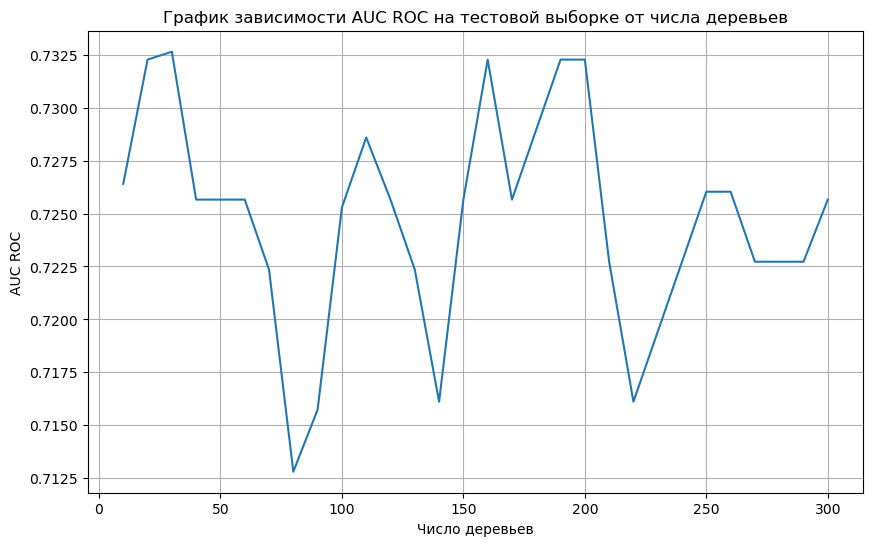

In [239]:
auc_roc_scores = []
estimators = list(range(10, 301, 10))

for n_estimators in estimators: #проходимся циклом по всем значеним количества деревьев и сохраняем auc_roc каждого в список
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=best_max_depth, min_samples_split=best_min_samples_split, random_state=42)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    auc_roc_scores.append(roc_auc)
    
plt.figure(figsize=(10, 6))
plt.plot(estimators, auc_roc_scores)
plt.title('График зависимости AUC ROC на тестовой выборке от числа деревьев')
plt.xlabel('Число деревьев')
plt.ylabel('AUC ROC')
plt.grid()
plt.show()

#auc-roc не зависит от количества деревьев, все расхождение данных происходит в районе 2 десятых

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

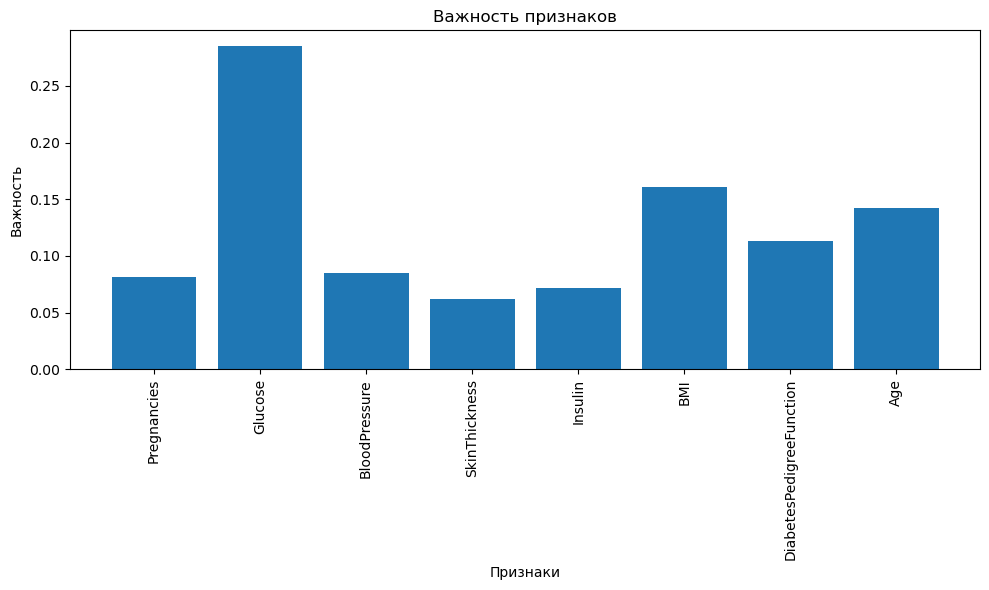

In [336]:
plt.figure(figsize=(10, 6))
plt.bar(X.columns, best_rf_clf.feature_importances_)
plt.title('Важность признаков')
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# так, мы видим, что важнейшим фактором для определения диабета является уровень клюкозы в крови